<a href="https://colab.research.google.com/github/GDD-Nantes/LLM4SchemaOrg/blob/main/LLM4SchemaOrg_Experimental_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tiktoken matplotlib seaborn scipy srsly fastparquet

# Assemble the results

In [2]:
!wget https://zenodo.org/records/14391666/files/LLM4SchemaOrg.zip?download=1 -O LLM4SchemaOrg.zip
!unzip -o LLM4SchemaOrg.zip

zsh:1: no matches found: https://zenodo.org/records/14391666/files/LLM4SchemaOrg.zip?download=1
unzip:  cannot find or open LLM4SchemaOrg.zip, LLM4SchemaOrg.zip.zip or LLM4SchemaOrg.zip.ZIP.


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
#@title Assemble document related statistics (n_chunks, n_tokens)
#@markdown As you can see, 50% of documents fit in the windows context (having 1 chunk). Therefore it's safe to perform statistical tests of 1 chunk vs many chunks.
from glob import glob
from itertools import chain
import re
import srsly
import pandas as pd
from pathlib import Path
import math
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-") #cl100k_base, same with gpt-4


document_files = chain(
    glob("data/WDC/Pset/pset_length/stratum*/corpus/*.txt", recursive=True),
    glob("data/WDC/Pset/count_sum/stratum*/corpus/*.txt", recursive=True)
)

document_records = []
for document_file in document_files:
    patt = r".*/(pset_length|count_sum)/(stratum_\d+)/corpus/([a-z0-9]{32})\.txt"
    m = re.search(patt, document_file)
    if m is None:
        print(document_file)

    document_text = Path(document_file).read_text()

    n_tokens = len(enc.encode(document_text))
    n_chunks = math.ceil(n_tokens/4096) # Overflow

    document_records.append({
        "sampling_feature": m.group(1),
        "stratum": m.group(2),
        "document_id": m.group(3),
        "n_tokens": n_tokens,
        "n_chunks": n_chunks,
        "n_chunks_cat": "1" if n_chunks == 1 else "> 1"
    })

document_df = pd.DataFrame.from_records(document_records)
document_df

,sampling_feature,stratum,document_id,n_tokens,n_chunks,n_chunks_cat
0,pset_length,stratum_2,75962c70372e9caff03878fd556fa4fe,6093,2,> 1
1,pset_length,stratum_2,b84130ee1d9f5c45d472589f1b617cd2,8303,3,> 1
2,pset_length,stratum_2,1e13a061cd2df273dbb4fc7e927b3c31,14748,4,> 1
3,pset_length,stratum_2,f8ec530d1621c930ad6182e1d71cc3c1,5510,2,> 1
4,pset_length,stratum_2,12a84c0d78bc1915e9726cff734c96b9,7366,2,> 1
...,...,...,...,...,...,...
178,count_sum,stratum_0,901936890128a9e16b1cd63b37fe781a,7222,2,> 1
179,count_sum,stratum_0,0c0340d4922afe932f0650a5f341e828,30785,8,> 1
180,count_sum,stratum_0,6a905dffb223f30d977079a5c45c7b43,2428,1,1
181,count_sum,stratum_0,5acb13a6d1776ceab442df15ac28488a,1583,1,1


In [5]:
#@title Proportions of #Chunks in the corpus
document_df["n_chunks"].value_counts(normalize=True)

n_chunks
1     0.508197
2     0.251366
3     0.114754
4     0.054645
5     0.038251
6     0.010929
8     0.010929
17    0.005464
7     0.005464
Name: proportion, dtype: float64

In [6]:
#@title Basic stats on #Chunks
document_df["n_chunks"].describe()

count    183.000000
mean       2.049180
std        1.770574
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       17.000000
Name: n_chunks, dtype: float64

In [7]:
stats_df = pd.read_parquet("data/WDC/Pset/stats.parquet")
stats_df.head(5)

,document_main_types,document_size_bytes,document_id,document_path,model,metric,document_sub_types,document_props,n_triples,score
0,None,20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,baseline,input,None,"[publisher, logo, url, name, datePublished, he...",11.0,NaN
1,None,20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,gpt3,input,None,"[headline, author, datePublished, articleBody,...",6.0,NaN
2,None,20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,gpt4,input,None,"[headline, author, name, datePublished, descri...",10.0,NaN
3,None,20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,baseline,shacl,None,"[publisher, logo, url, name, datePublished, he...",11.0,1.0
4,None,20415,4c33cd576d95af51d0dc099e12966ffa,data/WDC/Pset/pset_length/stratum_1/corpus/4c3...,gpt3,shacl,None,"[headline, author, datePublished, articleBody,...",6.0,1.0


In [8]:
#@title Assemble pipeline results
xp_df = pd.read_csv("data/WDC/Pset/results.csv")
xp_df = pd.merge(
    xp_df,
    stats_df[["document_id", "document_size_bytes"]].drop_duplicates(),
    on="document_id",
    suffixes=("", "_input")
)

xp_df = pd.merge(
    xp_df,
    document_df,
    on=["stratum", "document_id"]
)

def calc_rejection_rate(row):
    n_triples_input = xp_df[
        (xp_df["metric"] == "input") &
        (xp_df["approach"] == row["approach"]) &
        (xp_df["instance"] == row["instance"]) &
        (xp_df["sample_feature"] == row["sample_feature"]) &
        (xp_df["stratum"] == row["stratum"]) &
        (xp_df["document_classes"] == row["document_classes"]) &
        (xp_df["document_id"] == row["document_id"])
    ]["n_triples"].item()

    # print(n_triples_input)
    n_triples_output = row["n_triples"]
    return 1 - n_triples_output / n_triples_input

def rename_approach(row):
    if row["instance"] == "expected":
        return "Human"
    return row["approach"]

def rename_metric(x):
    if x == "semantic":
        return "compliance"
    elif x == "input":
        return "input"
    elif x == "factual":
        return "factuality"
    elif x == "jaccardms":
        return "mimr"
    elif x == "shacl":
        return "validity"
    else:
        return x

def rename_instance(x):
    if x == "pred":
        return "LLMs"
    elif x == "expected":
        return "Human"
    else:
        return x

xp_df["metric"] = xp_df["metric"].apply(rename_metric)
xp_df["instance"] = xp_df["instance"].apply(rename_instance)
xp_df["approach"] = xp_df.apply(rename_approach, axis=1)
xp_df["rejection_rate"] = xp_df.apply(calc_rejection_rate, axis=1)

xp_df

,metric,approach,instance,value,prompt_ver,n_triples,sample_feature,stratum,document_id,document_classes,document_size_bytes,sampling_feature,n_tokens,n_chunks,n_chunks_cat,rejection_rate
0,compliance,GPT_4_Turbo_Preview,LLMs,1.000000,text2kg_prompt3,10.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,1,0.655172
1,compliance,GPT_4_Turbo_Preview,Human,1.000000,text2kg_prompt3,4.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,1,0.714286
2,input,GPT_4_Turbo_Preview,LLMs,0.000000,text2kg_prompt3,29.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,1,0.000000
3,input,GPT_4_Turbo_Preview,Human,0.000000,text2kg_prompt3,14.0,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,1,0.000000
4,mimr,GPT_4_Turbo_Preview,LLMs,1.000000,text2kg_prompt3,NaN,pset_length,stratum_1,7d7a317d2ba15dc594fcb8a29739b54c,WebPage_Organization,5426,pset_length,1368,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,mimr,GPT_3_Turbo_16K,Human,0.830189,text2kg_prompt3,NaN,count_sum,stratum_2,605876ec12f2c6a03b4779d2e487be62,ItemPage,4316,count_sum,1847,1,1,NaN
3956,compliance,GPT_3_Turbo_16K,LLMs,0.909091,text2kg_prompt3,10.0,count_sum,stratum_2,605876ec12f2c6a03b4779d2e487be62,ItemPage,4316,count_sum,1847,1,1,0.333333
3957,compliance,GPT_3_Turbo_16K,Human,0.695652,text2kg_prompt3,15.0,count_sum,stratum_2,605876ec12f2c6a03b4779d2e487be62,ItemPage,4316,count_sum,1847,1,1,0.594595
3958,mimr,GPT_3_Turbo_16K,LLMs,0.333333,text2kg_prompt3,NaN,count_sum,stratum_2,6f90084b4766a0b5e6ecbacb9dcd065d,DiscussionForumPosting,19297,count_sum,9824,3,> 1,NaN


# Human vs LLMs

## Chunk size distribution

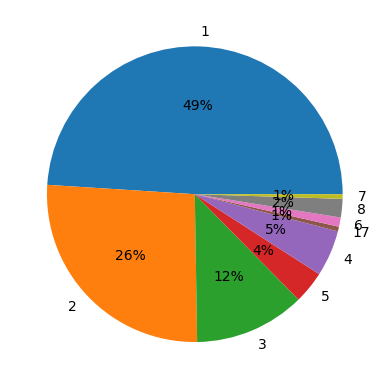

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Assuming the necessary data loading and merging steps from the previous code are executed

# Create the line plot
# plt.figure(figsize=(10, 6))
# sns.histplot(data=xp_df, x="n_chunks", kde=True)
counter = Counter(xp_df["n_chunks"].to_list())

palette_color = sns.color_palette("tab10")

# plotting data on chart
plt.pie(counter.values(), labels=counter.keys(), colors=palette_color, autopct='%.0f%%')

# Set labels and
# plt.legend()
plt.show()

## Rejection Rate per Number of Chunks

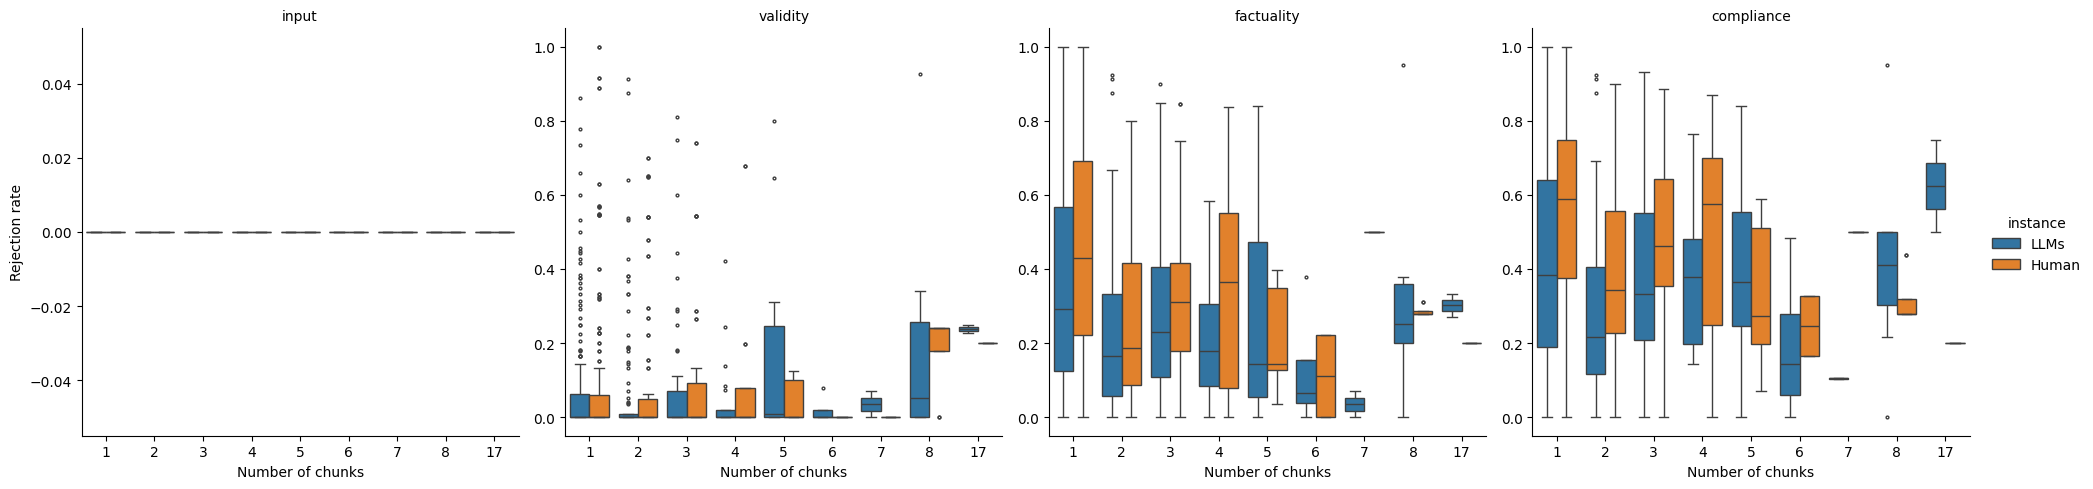

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['input', 'validity', 'factuality', 'compliance']

# Create the line plot
g = sns.catplot(
    data=xp_df.query("`metric` in @cols"),
    x='n_chunks', y='rejection_rate', hue='instance',
    col='metric', kind='box',
    col_order=cols, fliersize=2,
    sharey=False
)

g.set_axis_labels("Number of chunks", "Rejection rate")
g.set_titles(col_template="{col_name}")
plt.show()

## MIMR per Number of Chunks

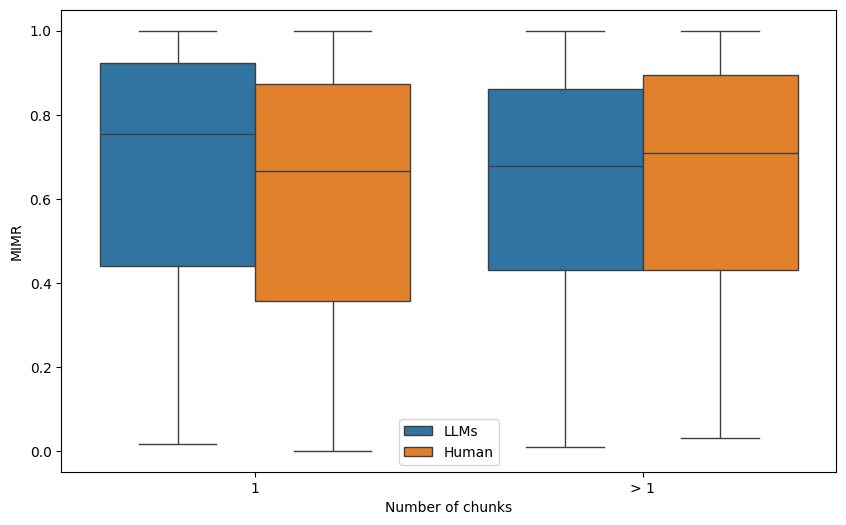

In [11]:
# prompt: Using seaborn, make a line plot with document_size on X-axis and semantic on Y-axis

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the necessary data loading and merging steps from the previous code are executed

# Create the line plot
plt.figure(figsize=(10, 6))
g = sns.boxplot(
    data=xp_df.query("`metric` == 'mimr'"),
    x="n_chunks_cat", y="value", hue="instance",
)

# Set labels and
plt.xlabel("Number of chunks")
plt.ylabel("MIMR")
# plt.title("Human vs LLMs: MIMR")
plt.legend()
plt.show()

# Effect of chunking on MIMR

In [12]:
from scipy.stats import ttest_ind

# Group data by document_size_cat
grouped = xp_df[xp_df["metric"] == "mimr"].groupby("n_chunks_cat")
one_chunk, many_chunks = [group["value"] for _, group in grouped]

t_statistic, p_value = ttest_ind(one_chunk, many_chunks, alternative="greater")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")
print("-" * 20)
if p_value < 0.05:
    print("There is a statistically significant degradation od MIMR when chunking")
else:
    print("There is no statistically significant degradation od MIMR when chunking")

T-statistic: 0.26192021562184087
P-value: 0.39672561492499436
--------------------
There is no statistically significant degradation od MIMR when chunking


## How do LLMs and Human compare?

In [13]:
result = xp_df.pivot_table(
    columns=["approach", "sample_feature", "stratum", "instance", "metric"],
    values=["value", "n_triples"],
    aggfunc={"n_triples": "sum", "value": "mean"}
).T
result

n_triples  \
approach            sample_feature stratum   instance metric                  
GPT_3_Turbo_16K     count_sum      stratum_0 Human    compliance      402.0   
                                                      factuality      463.0   
                                                      input           910.0   
                                                      mimr              0.0   
                                                      validity        748.0   
...                                                                     ...   
GPT_4_Turbo_Preview pset_length    stratum_2 LLMs     compliance      572.0   
                                                      factuality      637.0   
                                                      input           938.0   
                                                      mimr              0.0   
                                                      validity        847.0   

                                                                     value  
approach            sample_feature stratum   instance metric                
GPT_3_Turbo_16K     count_sum      stratum_0 Human    compliance  0.896035  
                                                      factuality  0.708642  
                                                      input       0.000000  
                                                      mimr        0.602959  
                                                      validity    0.948193  
...                                                                    ...  
GPT_4_Turbo_Preview pset_length    stratum_2 LLMs     compliance  0.920952  
                                                      factuality  0.775310  
                                                      input       0.000000  
                                                      mimr        0.567492  
                                                      validity    0.955724  

[120 rows x 2 columns]

In [14]:
#@title Results per sampling feature (\#instance per c-set or \#properties per c-set) and per quantile (Low, Med, High)
result.query("sample_feature == 'pset_length' and stratum == 'stratum_2'")

n_triples  \
approach            sample_feature stratum   instance metric                  
GPT_3_Turbo_16K     pset_length    stratum_2 Human    compliance      867.0   
                                                      factuality     1032.0   
                                                      input          1605.0   
                                                      mimr              0.0   
                                                      validity       1528.0   
                                             LLMs     compliance      366.0   
                                                      factuality      387.0   
                                                      input           545.0   
                                                      mimr              0.0   
                                                      validity        496.0   
GPT_4_Turbo_Preview pset_length    stratum_2 Human    compliance      867.0   
                                                      factuality     1032.0   
                                                      input          1605.0   
                                                      mimr              0.0   
                                                      validity       1528.0   
                                             LLMs     compliance      572.0   
                                                      factuality      637.0   
                                                      input           938.0   
                                                      mimr              0.0   
                                                      validity        847.0   

                                                                     value  
approach            sample_feature stratum   instance metric                
GPT_3_Turbo_16K     pset_length    stratum_2 Human    compliance  0.864333  
                                                      factuality  0.678985  
                                                      input       0.000000  
                                                      mimr        0.772947  
                                                      validity    0.958164  
                                             LLMs     compliance  0.949276  
                                                      factuality  0.790187  
                                                      input       0.000000  
                                                      mimr        0.480739  
                                                      validity    0.937136  
GPT_4_Turbo_Preview pset_length    stratum_2 Human    compliance  0.864333  
                                                      factuality  0.678985  
                                                      input       0.000000  
                                                      mimr        0.704814  
                                                      validity    0.958164  
                                             LLMs     compliance  0.920952  
                                                      factuality  0.775310  
                                                      input       0.000000  
                                                      mimr        0.567492  
                                                      validity    0.955724

# Factuality Checker: results breakdown

In [15]:
#@title Assemble results
from glob import glob
from itertools import chain
import re
import srsly
import pandas as pd

factuality_reports = chain(
    glob("data/WDC/Pset/**/**factual_pred.json", recursive=True),
    glob("data/WDC/Pset/**/**factual_expected.json", recursive=True)
)

factuality_records = []
for factuality_report in factuality_reports:
    patt = r".*/(pset_length|count_sum)/(stratum_\d+)/corpus/(\w+)(/(text2kg_prompt3))?/([a-z0-9]{32})_(\w+)_factual_(pred|expected)\.json"
    m = re.search(patt, factuality_report)
    if m is None:
        print(factuality_report)

    report_data = srsly.read_json(factuality_report)

    for chunk_name, chunk in report_data.items():
        for query in chunk.keys():
            if query in ["status", "score"]:
                continue

            if chunk_name == "aggregation":
                continue

            prop, value, parent = query.split("[TOK_Q_DELIM]")
            response = chunk[query]["response"]
            if response == "TOKPOS":
                response = "positive"
            elif response == "TOKNEG":
                response = "negative"

            factuality_records.append({
                "sampling_feature": m.group(1),
                "stratum": m.group(2),
                "model": m.group(3),
                "prompt": m.group(5),
                "document_id": m.group(6),
                "document_classes": m.group(7).split("_"),
                "instance": m.group(8),
                "property": prop,
                "response": response,
                "value": value,
                "parent": parent,
            })

factuality_df = pd.DataFrame.from_records(factuality_records)
factuality_df

,sampling_feature,stratum,model,prompt,document_id,document_classes,instance,property,response,value,parent
0,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,345759b16a979ca20c5e22ef78c9c3a4,[LocalBusiness],pred,name,positive,Fitness Services,OfferCatalog
1,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,345759b16a979ca20c5e22ef78c9c3a4,[LocalBusiness],pred,image,positive,https://signaturefitnessnj.com/wp-content/uplo...,LocalBusiness
2,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,345759b16a979ca20c5e22ef78c9c3a4,[LocalBusiness],pred,bestRating,positive,5,Rating
3,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,345759b16a979ca20c5e22ef78c9c3a4,[LocalBusiness],pred,logo,positive,https://signaturefitnessnj.com/wp-content/uplo...,LocalBusiness
4,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,345759b16a979ca20c5e22ef78c9c3a4,[LocalBusiness],pred,url,positive,https://signaturefitnessnj.com,LocalBusiness
...,...,...,...,...,...,...,...,...,...,...,...
20179,count_sum,stratum_0,baseline,None,b1d3e5fded9ad21c44207026c0acd40b,[City],expected,url,positive,https://chine365.fr/voyage/pekin/,City
20180,count_sum,stratum_0,baseline,None,b1d3e5fded9ad21c44207026c0acd40b,[City],expected,name,positive,Pékin,City
20181,count_sum,stratum_0,baseline,None,b1d3e5fded9ad21c44207026c0acd40b,[City],expected,description,positive,Avec une histoire remontant à plus de 3000 ans...,City
20182,count_sum,stratum_0,baseline,None,b1d3e5fded9ad21c44207026c0acd40b,[City],expected,photo,positive,https://chine365.fr/images/2000x1300/pekin.jpg,City


In [16]:
#@title Top 10 properties per label (positive/negative)

from collections import Counter

def filter_common_elements(row, topk=10):
    factual = row.xs("positive", level="response")
    non_factual = row.xs("negative", level="response")

    new_factuals = []
    new_non_factuals = []

    for f, nf in zip(factual, non_factual):
        f_keys = set(f.keys()) - set(nf.keys())
        nf_keys = set(nf.keys()) - set(f.keys())
        new_f = Counter({ k: v for k, v in f.items() if k in f_keys })
        new_nf = Counter({ k: v for k, v in nf.items() if k in nf_keys })
        new_factuals.append(new_f)
        new_non_factuals.append(new_nf)

    # row.loc[(slice(None), 'factual')] = new_factuals
    # row.loc[(slice(None), 'factual')] = new_non_factuals
    # return row

    # Assign the new values back to the row
    for idx in row.index:
        if idx[1] == 'positive':
            row[idx] = new_factuals.pop(0)
        elif idx[1] == 'negative':
            row[idx] = new_non_factuals.pop(0)
    return row

result_df = (
    factuality_df
        .pivot_table(
            columns=["model", "response"],
            values=["property"],
            aggfunc={
                "property": Counter,
            }
        )
    #.apply(filter_common_elements, axis=1)
    .apply(lambda x: pd.Series(x.item().most_common(10)))
    # .apply(lambda x: pd.Series([v for v in x.item().values()]))
    # .sum()
)

(
    result_df
    .loc[:, result_df.columns.get_level_values('response') == 'negative']
)

model,GPT_3_Turbo_16K,GPT_4_Turbo_Preview,baseline
response,negative,negative,negative
0,"(name, 342)","(sameAs, 209)","(name, 403)"
1,"(url, 118)","(name, 203)","(sameAs, 321)"
2,"(datePublished, 85)","(url, 90)","(url, 153)"
3,"(position, 48)","(datePublished, 90)","(datePublished, 83)"
4,"(sameAs, 39)","(image, 87)","(email, 36)"
5,"(image, 35)","(telephone, 67)","(telephone, 35)"
6,"(dayOfWeek, 25)","(email, 51)","(additionalType, 33)"
7,"(email, 23)","(significantLink, 47)","(height, 32)"
8,"(telephone, 18)","(isBasedOnUrl, 47)","(dateModified, 30)"


# Compliance Checker: results breakdown

In [17]:
#@title Assemble results
from glob import glob
from itertools import chain
import re
import srsly
import pandas as pd

compliance_reports = chain(
    glob("data/WDC/Pset/**/**semantic_pred.json", recursive=True),
    glob("data/WDC/Pset/**/**semantic_expected.json", recursive=True)
)

compliance_records = []
for compliance_report in compliance_reports:
    patt = r".*/(pset_length|count_sum)/(stratum_\d+)/corpus/(\w+)(/(text2kg_prompt3))?/([a-z0-9]{32})_(\w+)_semantic_(pred|expected)\.json"
    m = re.search(patt, compliance_report)
    if m is None:
        print(compliance_report)

    report_data = srsly.read_json(compliance_report)

    for chunk_name, chunk in report_data.items():
        for query in chunk.keys():
            if query in ["status", "score"]:
                continue

            if chunk_name == "aggregation":
                continue

            prop, value, parent = query.split("[TOK_Q_DELIM]")
            response = chunk[query]["response"]
            if response == "TOKPOS":
                response = "positive"
            elif response == "TOKNEG":
                response = "negative"

            compliance_records.append({
                "sampling_feature": m.group(1),
                "stratum": m.group(2),
                "model": m.group(3),
                "prompt": m.group(5),
                "document_id": m.group(6),
                "document_classes": m.group(7).split("_"),
                "instance": m.group(8),
                "property": prop,
                "response": response,
                "value": value,
                "parent": parent,
            })

compliance_df = pd.DataFrame.from_records(compliance_records)
compliance_df

,sampling_feature,stratum,model,prompt,document_id,document_classes,instance,property,response,value,parent
0,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,734cd1d8b608c3f0fc896daf27e0723f,[Attorney],pred,image,positive,https://3rxopm21eqdw3zltqg31f54g-wpengine.netd...,Attorney
1,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,734cd1d8b608c3f0fc896daf27e0723f,[Attorney],pred,image,positive,https://3rxopm21eqdw3zltqg31f54g-wpengine.netd...,Attorney
2,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,734cd1d8b608c3f0fc896daf27e0723f,[Attorney],pred,addressRegion,positive,TX,PostalAddress
3,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,734cd1d8b608c3f0fc896daf27e0723f,[Attorney],pred,description,positive,The Cobos Law Firm specializes in helping 18-w...,Attorney
4,pset_length,stratum_2,GPT_4_Turbo_Preview,text2kg_prompt3,734cd1d8b608c3f0fc896daf27e0723f,[Attorney],pred,streetAddress,positive,711 W. Alabama,PostalAddress
...,...,...,...,...,...,...,...,...,...,...,...
9604,count_sum,stratum_0,baseline,None,ac38c6350995b98d6b3c7cd747f79c3a,[CollegeOrUniversity],expected,legalName,positive,University College Cork,CollegeOrUniversity
9605,count_sum,stratum_0,baseline,None,85dbd65454c826fe344bb1963578591f,[Person],expected,name,positive,Clarence Albrecht (deceased),Person
9606,count_sum,stratum_0,baseline,None,85dbd65454c826fe344bb1963578591f,[Person],expected,name,positive,Cynthia Albrecht,Person
9607,count_sum,stratum_0,baseline,None,85dbd65454c826fe344bb1963578591f,[Person],expected,name,positive,Maureen (Bond) Albrecht (deceased),Person


In [18]:
#@title Top 10 properties per label (positive/negative)

from collections import Counter

def filter_common_elements(row, topk=10):
    factual = row.xs("positive", level="response")
    non_factual = row.xs("negative", level="response")

    new_factuals = []
    new_non_factuals = []

    for f, nf in zip(factual, non_factual):
        f_keys = set(f.keys()) - set(nf.keys())
        nf_keys = set(nf.keys()) - set(f.keys())
        new_f = Counter({ k: v for k, v in f.items() if k in f_keys })
        new_nf = Counter({ k: v for k, v in nf.items() if k in nf_keys })
        new_factuals.append(new_f)
        new_non_factuals.append(new_nf)

    # row.loc[(slice(None), 'factual')] = new_factuals
    # row.loc[(slice(None), 'factual')] = new_non_factuals
    # return row

    # Assign the new values back to the row
    for idx in row.index:
        if idx[1] == 'positive':
            row[idx] = new_factuals.pop(0)
        elif idx[1] == 'negative':
            row[idx] = new_non_factuals.pop(0)
    return row

result_df = (
    compliance_df
        .pivot_table(
            columns=["model", "response"],
            values=["property"],
            aggfunc={
                "property": Counter,
            }
        )
    #.apply(filter_common_elements, axis=1)
    .apply(lambda x: pd.Series(x.item().most_common(10)))
    # .apply(lambda x: pd.Series([v for v in x.item().values()]))
    # .sum()
)

(
    result_df
    .loc[:, result_df.columns.get_level_values('response') == 'negative']
)

model,GPT_3_Turbo_16K,GPT_4_Turbo_Preview,baseline
response,negative,negative,negative
0,"(position, 224)","(significantLink, 59)","(keywords, 36)"
1,"(text, 21)","(streetAddress, 26)","(hasPart, 35)"
2,"(name, 16)","(value, 24)","(url, 34)"
3,"(contentUrl, 15)","(jobTitle, 22)","(price, 34)"
4,"(keywords, 11)","(keywords, 20)","(knowsAbout, 27)"
5,"(recipeIngredient, 9)","(recipeIngredient, 18)","(openingHours, 22)"
6,"(addressCountry, 8)","(sameAs, 17)","(position, 17)"
7,"(value, 7)","(serviceArea, 15)","(name, 14)"
8,"(addressLocality, 6)","(image, 14)","(sameAs, 14)"


# Human evaluation

In [19]:
!wget https://github.com/GDD-Nantes/MarkupGeneratorABTest/raw/main/ab_gpt3.csv -O ab_gpt3.csv
!wget https://github.com/GDD-Nantes/MarkupGeneratorABTest/raw/main/ab_gpt4.csv -O ab_gpt4.csv

--2025-04-23 15:43:44--  https://github.com/GDD-Nantes/MarkupGeneratorABTest/raw/main/ab_gpt3.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/GDD-Nantes/LLM4SchemaOrgABTest/raw/main/ab_gpt3.csv [following]
--2025-04-23 15:43:44--  https://github.com/GDD-Nantes/LLM4SchemaOrgABTest/raw/main/ab_gpt3.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GDD-Nantes/LLM4SchemaOrgABTest/main/ab_gpt3.csv [following]
--2025-04-23 15:43:44--  https://raw.githubusercontent.com/GDD-Nantes/LLM4SchemaOrgABTest/main/ab_gpt3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:

In [34]:
import re
from collections import Counter
import pandas as pd

ab_v3_df = pd.read_csv("ab_gpt3.csv")
ab_v4_df = pd.read_csv("ab_gpt4.csv")

ab_v3_df["instance"] = "gpt3"
ab_v4_df["instance"] = "gpt4"

ab_df = (
    pd.concat([ab_v3_df, ab_v4_df])
    .drop(["Timestamp", "Score", "Email Address"], axis=1)
    .replace("They are tied (They are all good or all bad)", "Tie")
)

ab_df.columns = [re.search(r"([a-z0-9]+):", c).group(1) if re.search(r"([a-z0-9]+):", c) else c for c in ab_df.columns]
ab_df.rename(columns={"On a scale from 1 to 5, how familiar are you with interpreting JSON-LD data?": "familiarity"}, inplace=True)
print(ab_df["familiarity"].value_counts(normalize=True))
# ab_df["familiarity"] = ab_df["familiarity"].astype(int)
ab_df = ab_df.query("`familiarity` > 0")
ab_df.drop(columns=["familiarity"], inplace=True)
ab_df = ab_df.pivot_table(columns="instance", aggfunc=Counter)
ab_df

familiarity
5.0    0.419355
1.0    0.258065
4.0    0.193548
3.0    0.129032
Name: proportion, dtype: float64


instance,gpt4
03bc1aedb07a529cdac7b7d9db6ac56b,"{'Markup B': 28, 'Tie': 2, 'Markup A': 1}"
0aab606677703ad0eaa5112790b22eec,"{'Markup B': 26, 'Tie': 2, 'Markup A': 3}"
12a84c0d78bc1915e9726cff734c96b9,"{'Markup B': 9, 'Markup A': 13, 'Tie': 9}"
1bce98c5308e236f65e62a59ff815433,"{'Markup A': 11, 'Tie': 11, 'Markup B': 9}"
1f4045db11d90414c07f1bd73f8979ab,"{'Markup A': 12, 'Markup B': 9, 'Tie': 10}"
21a447da550c501812e5f3148cd3b223,"{'Tie': 14, 'Markup B': 13, 'Markup A': 4}"
227469efe35728531f290e566030400d,"{'Tie': 11, 'Markup B': 17, 'Markup A': 3}"
2e92108eeef6af0c24a5637f12ce7264,"{'Markup A': 12, 'Tie': 8, 'Markup B': 11}"
345759b16a979ca20c5e22ef78c9c3a4,"{'Markup B': 22, 'Tie': 5, 'Markup A': 4}"
371a8cb5b6376e4b439888947cbef875,"{'Markup B': 27, 'Markup A': 3, 'Tie': 1}"


In [35]:

def assign_score(x):
    score = {
        "Markup A": 0,
        "Markup B": 0,
    }

    for response, count in x.items():
        if response == "Tie":
            score["Markup A"] += count
            score["Markup B"] += count
        else:
            score[response] += count

    return score

def assign_winner(x):
    _, max_count = x.most_common(1)[0]
    max_items = [ k for k, v in x.items() if v == max_count ]
    # If there is a clear winner
    if len(max_items) == 1:
        return max_items[0]
    return "Tie"

ab_per_doc = ab_df.apply(lambda x: x.apply(assign_winner))
ab_per_doc

instance,gpt4
03bc1aedb07a529cdac7b7d9db6ac56b,Markup B
0aab606677703ad0eaa5112790b22eec,Markup B
12a84c0d78bc1915e9726cff734c96b9,Markup A
1bce98c5308e236f65e62a59ff815433,Tie
1f4045db11d90414c07f1bd73f8979ab,Markup A
21a447da550c501812e5f3148cd3b223,Tie
227469efe35728531f290e566030400d,Markup B
2e92108eeef6af0c24a5637f12ce7264,Markup A
345759b16a979ca20c5e22ef78c9c3a4,Markup B
371a8cb5b6376e4b439888947cbef875,Markup B


In [36]:
mimir = xp_df.pivot_table(index="document_id", columns=["approach", "instance", "metric"], values="value", aggfunc="mean")
mimir

approach                         GPT_3_Turbo_16K                             \
instance                                   Human                              
metric                                compliance factuality input      mimr   
document_id                                                                   
00452a06e9cc4f50088ba755ac4200c3        1.000000   0.625000   0.0  0.857143   
010fe200abe39e41b44cc685ea3daaaf        0.800000   1.000000   0.0  0.875000   
01960fe2283a00855e55b86932ef56a0        0.882353   0.653846   0.0  0.846154   
02f415c4c32d5448a47810e8a1ca3c78        1.000000   0.666667   0.0  0.031579   
03bc1aedb07a529cdac7b7d9db6ac56b        0.600000   0.600000   0.0  0.571429   
...                                          ...        ...   ...       ...   
fdc0c0d51e6df46f36843dc071f2f04f             NaN        NaN   0.0  0.731544   
fe64a80e4a7976d977d4c0c1894d27cd        1.000000   1.000000   0.0  0.166667   
ff54b11443138f583d50d2ebb03c0936        0.916667   0.933333   0.0  0.690476   
ffaa62434d1aa95419b80992efc8f22f        0.600000   0.500000   0.0  0.678571   
ffc6598961ef48ac12d1d3131a6fca4f        0.700000   0.714286   0.0  0.833333   

approach                                                                \
instance                                         LLMs                    
metric                            validity compliance factuality input   
document_id                                                              
00452a06e9cc4f50088ba755ac4200c3  1.000000   1.000000   0.666667   0.0   
010fe200abe39e41b44cc685ea3daaaf  1.000000   1.000000   0.666667   0.0   
01960fe2283a00855e55b86932ef56a0  0.962963   1.000000   0.818182   0.0   
02f415c4c32d5448a47810e8a1ca3c78  1.000000   0.962264   1.000000   0.0   
03bc1aedb07a529cdac7b7d9db6ac56b  1.000000   0.750000   0.800000   0.0   
...                                    ...        ...        ...   ...   
fdc0c0d51e6df46f36843dc071f2f04f  0.485714   0.730769   0.825397   0.0   
fe64a80e4a7976d977d4c0c1894d27cd  1.000000   1.000000   1.000000   0.0   
ff54b11443138f583d50d2ebb03c0936  1.000000   0.969697   1.000000   0.0   
ffaa62434d1aa95419b80992efc8f22f  1.000000   1.000000   0.461538   0.0   
ffc6598961ef48ac12d1d3131a6fca4f  0.937500   0.600000   0.714286   0.0   

approach                                             GPT_4_Turbo_Preview  \
instance                                                           Human   
metric                                mimr  validity          compliance   
document_id                                                                
00452a06e9cc4f50088ba755ac4200c3  0.428571  1.000000            1.000000   
010fe200abe39e41b44cc685ea3daaaf  0.500000  1.000000            0.800000   
01960fe2283a00855e55b86932ef56a0  0.615385  1.000000            0.882353   
02f415c4c32d5448a47810e8a1ca3c78  0.989474  0.929825            1.000000   
03bc1aedb07a529cdac7b7d9db6ac56b  0.571429  1.000000            0.600000   
...                                    ...       ...                 ...   
fdc0c0d51e6df46f36843dc071f2f04f  0.704698  1.000000                 NaN   
fe64a80e4a7976d977d4c0c1894d27cd  1.000000  1.000000            1.000000   
ff54b11443138f583d50d2ebb03c0936  0.488624  0.698413            0.916667   
ffaa62434d1aa95419b80992efc8f22f  0.571429  0.673469            0.600000   
ffc6598961ef48ac12d1d3131a6fca4f  0.500000  1.000000            0.700000   

approach                                                               \
instance                                                                
metric                           factuality input      mimr  validity   
document_id                                                             
00452a06e9cc4f50088ba755ac4200c3   0.625000   0.0  0.352941  1.000000   
010fe200abe39e41b44cc685ea3daaaf   1.000000   0.0  0.583333  1.000000   
01960fe2283a00855e55b86932ef56a0   0.653846   0.0  0.293333  0.962963   
02f415c4c32d5448a47810e8a1ca3c78   0.666667   0.0  

In [37]:
def assign_label(row):
    return "Markup A" if row[0].item() > row[1].item() else "Markup B" if row[0].item() < row[1].item() else "Tie"

def assign_mimir_winner(row):
    expected_jaccardms = row.xs('mimr', level='metric').xs('Human', level='instance')
    predicted_jaccardms = row.xs('mimr', level='metric').xs('LLMs', level='instance')
    labels = expected_jaccardms.compare(predicted_jaccardms, keep_shape=True, keep_equal=True)
    return labels.apply(assign_label, axis=1)

mimir_per_doc = mimir.apply(assign_mimir_winner, axis=1)
mimir_per_doc

/tmp/ipykernel_301136/4170658750.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return "Markup A" if row[0].item() > row[1].item() else "Markup B" if row[0].item() < row[1].item() else "Tie"


approach,GPT_3_Turbo_16K,GPT_4_Turbo_Preview
document_id,,
00452a06e9cc4f50088ba755ac4200c3,Markup A,Markup B
010fe200abe39e41b44cc685ea3daaaf,Markup A,Markup B
01960fe2283a00855e55b86932ef56a0,Markup A,Markup B
02f415c4c32d5448a47810e8a1ca3c78,Markup B,Markup B
03bc1aedb07a529cdac7b7d9db6ac56b,Tie,Markup B
...,...,...
fdc0c0d51e6df46f36843dc071f2f04f,Markup A,Markup A
fe64a80e4a7976d977d4c0c1894d27cd,Markup B,Markup B
ff54b11443138f583d50d2ebb03c0936,Markup A,Markup B


In [38]:
final_ab_raw = (
    ab_per_doc
    .join(mimir_per_doc, how="inner")
    .rename(columns={
        "gpt3": "gpt3-h",
        "GPT_3_Turbo_16K": "gpt3-m",
        "gpt4": "gpt4-h",
        "GPT_4_Turbo_Preview": "gpt4-m"
    })
    .reindex(columns=["gpt3-h", "gpt3-m", "gpt4-h", "gpt4-m"])
    .reset_index(names="document_id")

)
final_ab_raw["document_id"] = final_ab_raw["document_id"].apply(lambda x: x[:5] + "...")
final_ab_raw = final_ab_raw.reindex(columns=["document_id", "gpt4-h", "gpt4-m"])
final_ab_raw

,document_id,gpt4-h,gpt4-m
0,03bc1...,Markup B,Markup B
1,0aab6...,Markup B,Markup B
2,12a84...,Markup A,Markup A
3,1bce9...,Tie,Markup B
4,1f404...,Markup A,Markup A
5,21a44...,Tie,Tie
6,22746...,Markup B,Markup B
7,2e921...,Markup A,Markup B
8,34575...,Markup B,Markup B
9,371a8...,Markup B,Markup B


In [39]:
def assign(row):
    """When one of the evaluator vote Tie, assign other's vote"""
    # if row["gpt3-h"] == "Tie":
    #     row["gpt3-h"] = row["gpt3-m"]
    # elif row["gpt3-m"] == "Tie":
    #     row["gpt3-m"] = row["gpt3-h"]

    if row["gpt4-h"] == "Tie":
        row["gpt4-h"] = row["gpt4-m"]
    elif row["gpt4-m"] == "Tie":
        row["gpt4-m"] = row["gpt4-h"]

    return row
final_ab = final_ab_raw.apply(assign, axis=1)
final_ab

,document_id,gpt4-h,gpt4-m
0,03bc1...,Markup B,Markup B
1,0aab6...,Markup B,Markup B
2,12a84...,Markup A,Markup A
3,1bce9...,Markup B,Markup B
4,1f404...,Markup A,Markup A
5,21a44...,Tie,Tie
6,22746...,Markup B,Markup B
7,2e921...,Markup A,Markup B
8,34575...,Markup B,Markup B
9,371a8...,Markup B,Markup B


In [40]:
final_ab_sum = final_ab_raw.set_index("document_id").apply(lambda x: pd.Series(assign_score(Counter(x))))
final_ab_sum

,gpt4-h,gpt4-m
Markup A,13,13
Markup B,27,24


In [41]:
from scipy.stats import fisher_exact
from sklearn.metrics import cohen_kappa_score

# Extract the relevant columns for the Chi-square test
# Assuming you want to compare each '-h' column with its corresponding '-m' column
columns_to_compare = [
    # ('gpt3-h', 'gpt3-m'),
    ('gpt4-h', 'gpt4-m')
]

# Series of statistic tests
results = {}
for col_h, col_m in columns_to_compare:
    # Contingency table analysis
    contingency_table = final_ab_sum[[col_h, col_m]].values
    fstat, f_pvalue = fisher_exact(contingency_table, alternative="two-sided")

    # Paired analysis
    human_votes = final_ab[col_h].values
    mimr_votes = final_ab[col_m].values

    cohen_kappa = cohen_kappa_score(human_votes, mimr_votes)

    results[f"{col_h} vs {col_m}"] = {
        'f_statistic': fstat,
        'f_pvalue': f_pvalue,
        'cohen_kappa': cohen_kappa
    }

# Print the results
for comparison, result in results.items():
    print("==============")
    print(f"Fischer statistic: {result['f_statistic']}")
    print(f"Fischer p-value: {result['f_pvalue']}")
    print(f"Cohen's Kappa statistic: {result['cohen_kappa']}")


Fischer statistic: 0.8888888888888888
Fischer p-value: 0.8147663206204219
Cohen's Kappa statistic: 0.823240589198036


# Debug tools


## HTML2Markdown

In [42]:
!pip install html2text

In [43]:
import html2text
def _html2txt(content, force=False):
    converter = html2text.HTML2Text()
    converter.ignore_links = False
    converter.ignore_images = False
    converter.ignore_tables = False
    converter.ignore_emphasis = False

    return converter.handle(content)

def preprocess_text(doc: str):
    # Tokenize the text
    tokens = word_tokenize(doc)

    # Remove punctuation and stop words
    tokens = [token for token in tokens if token.isalnum() and token not in set(stopwords.words('english'))]
    tokens = list(itertools.chain(*[camel_case_split(token) for token in tokens]))
    tokens = [token.lower() for token in tokens]

    return set(tokens)

def jaccard_similarity(doc1: str, doc2: str):
    a = preprocess_text(doc1)
    b = preprocess_text(doc2)
    return 1-jaccard_distance(a, b)

In [44]:
_html2txt("""
<h1>Crew neck white t-shirt</h1>

<p>White t-shirt  made of soft and lightweight cotton jersey,
ensuring comfort, a refined mélange texture adds sporty appeal.</p>
<a href="https://gs1.appareldemo.com/01/09506000164908">Manufacturer information</a>
""")

'# Crew neck white t-shirt\n\nWhite t-shirt made of soft and lightweight cotton jersey, ensuring comfort, a\nrefined mélange texture adds sporty appeal.\n\n[Manufacturer information](https://gs1.appareldemo.com/01/09506000164908)\n\n'

# Misc

## Languages

In [45]:
!wget https://commoncrawl.github.io/cc-crawl-statistics/plots/languages.csv -O languages.csv

--2025-04-23 15:44:16--  https://commoncrawl.github.io/cc-crawl-statistics/plots/languages.csv
Resolving commoncrawl.github.io (commoncrawl.github.io)... 2606:50c0:8000::153, 2606:50c0:8001::153, 2606:50c0:8002::153, ...
Connecting to commoncrawl.github.io (commoncrawl.github.io)|2606:50c0:8000::153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391170 (382K) [text/csv]
Saving to: ‘languages.csv’

languages.csv       100%[===================>] 382.00K  --.-KB/s    in 0.09s   

2025-04-23 15:44:17 (4.03 MB/s) - ‘languages.csv’ saved [391170/391170]



In [46]:
import pandas as pd

cc_langs = pd.read_csv("languages.csv").query("`crawl` == 'CC-MAIN-2022-40'")
cc_langs = cc_langs[["primary_language", "%pages/crawl"]]
cc_langs.reset_index(drop=True, inplace=True)
cc_langs.nlargest(5, "%pages/crawl")

,primary_language,%pages/crawl
31,eng,45.8786
114,rus,5.9692
27,deu,5.8811
160,zho,4.8747
66,jpn,4.7884


In [47]:
cc_langs

,primary_language,%pages/crawl
0,<unknown>,2.5673
1,aar,0.0001
2,abk,0.0008
3,afr,0.0084
4,aka,0.0001
...,...,...
157,yid,0.0017
158,yor,0.0010
159,zha,0.0001
160,zho,4.8747
